# Self-Driving Car Engineer Nanodegree | Computer Vision
## Project: Vehicle Detection
### by Mohit Arvind Khakharia


The goals / steps of this project are the following:

- Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
- Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector.
- Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
- Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
- Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
- Estimate a bounding box for vehicles detected.

In [112]:
## All the import statements necessary for the project
import numpy as np
import cv2
import matplotlib.pyplot as plt
import glob
import os
import random
from skimage.feature import hog
import csv
import time
from sklearn.model_selection import train_test_split
import matplotlib.image as mpimg
from sklearn.svm import LinearSVC
from scipy.ndimage.measurements import label
from moviepy.editor import VideoFileClip
from IPython.display import HTML


## Data Exploration
- Data was extracted from https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/vehicles.zip and https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/non-vehicles.zip

- Ensured that the number of positive and negative samples are of approximately the same count so that the learning is not biased.

Vehicle Length 8793
Non-Vehicle Length 8968
Shape of Images -  (64, 64, 3)


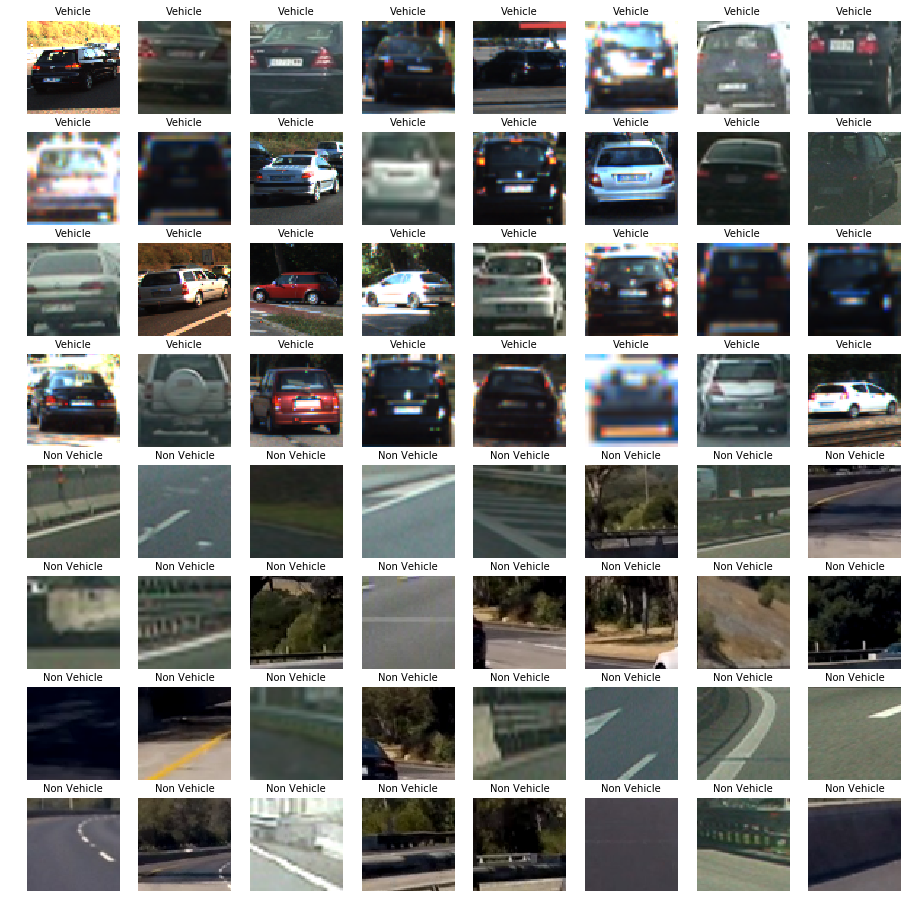

In [115]:
#Relative path to the dataset containing training images
vehicleFolder = 'data/vehicles'
nonVehicleFolder = 'data/non-vehicles'
file_types = ('jpg', 'png')
# read in and count datasets
files_vehicle = []
files_nonVehicle = []
#Loop and add it to the respective arrays
for ext in file_types:
    files_vehicle.extend(glob.glob('{}/**/*.{}'.format(vehicleFolder, ext), recursive=True))
    files_nonVehicle.extend(glob.glob('{}/**/*.{}'.format(nonVehicleFolder, ext), recursive=True))

print("Vehicle Length",len(files_vehicle))
print("Non-Vehicle Length",len(files_nonVehicle))
img = cv2.imread(files_vehicle[0])
print("Shape of Images - ",img.shape)

fig, axs = plt.subplots(8,8, figsize=(16, 16))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()

# Showing random samples with labels
# Vehciles
for i in np.arange(32):
    img = cv2.imread(files_vehicle[np.random.randint(0,len(files_vehicle))])
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    axs[i].axis('off')
    axs[i].set_title('Vehicle', fontsize=10)
    axs[i].imshow(img)
# Non-Vehicles
for i in np.arange(32,64):
    img = cv2.imread(files_nonVehicle[np.random.randint(0,len(files_nonVehicle))])
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    axs[i].axis('off')
    axs[i].set_title('Non Vehicle', fontsize=10)
    axs[i].imshow(img)

## Color Spaces | Get Histogram Features
### Reference - Udacity Self Driving Car Nanodegree - Lesson 20, section 12

In [116]:
# Create thresholded binary image
def convertChannel(img, colorspace='rgb', useChannel=0):
    '''
    The function converts the image to a given colorspace and returns the it.
    Note - It doesnt ravel/flatten it but returns the entire image. You can use ravel to extract features.
    '''
    # color space conversion
    if colorspace == 'gray':
        cvt_img = cv2.cvtColor(img, cv2.COLOR_BGRGRAY)
    elif colorspace == 'hsv':
        cvt_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    elif colorspace == 'hls':
        cvt_img = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    elif colorspace == 'lab':
        cvt_img = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    elif colorspace == 'luv':
        cvt_img = cv2.cvtColor(img, cv2.COLOR_BGR2LUV)
    elif colorspace == 'yuv':
        cvt_img = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
    elif colorspace == 'ycrcb':
        cvt_img = cv2.cvtColor(img, cv2.COLOR_BGR2YCR_CB)
    else: 
        cvt_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # isolate channel
    if colorspace != 'gray':
        cvt_img = cvt_img[:,:,useChannel]     

    return cvt_img


def get_colorHist_features(img, nbins=32, bins_range=(0, 256)):
    '''
    Returns the feaures of an image by concatening all the channels.
    '''
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    if img.shape[2] != 0:
        channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
        channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
        # Concatenate the histograms into a single feature vector
        features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    else:
        features = channel1_hist[0]    
    return features


def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    '''
    Computes and returns the histogram of gradients.
    '''
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                                  visualise=True, feature_vector=False)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                       visualise=False, feature_vector=feature_vec)
        return features

### Visualize Color channels along with HOG
### Reference - Udacity Self Driving Car Nanodegree - Lesson 20, section 18

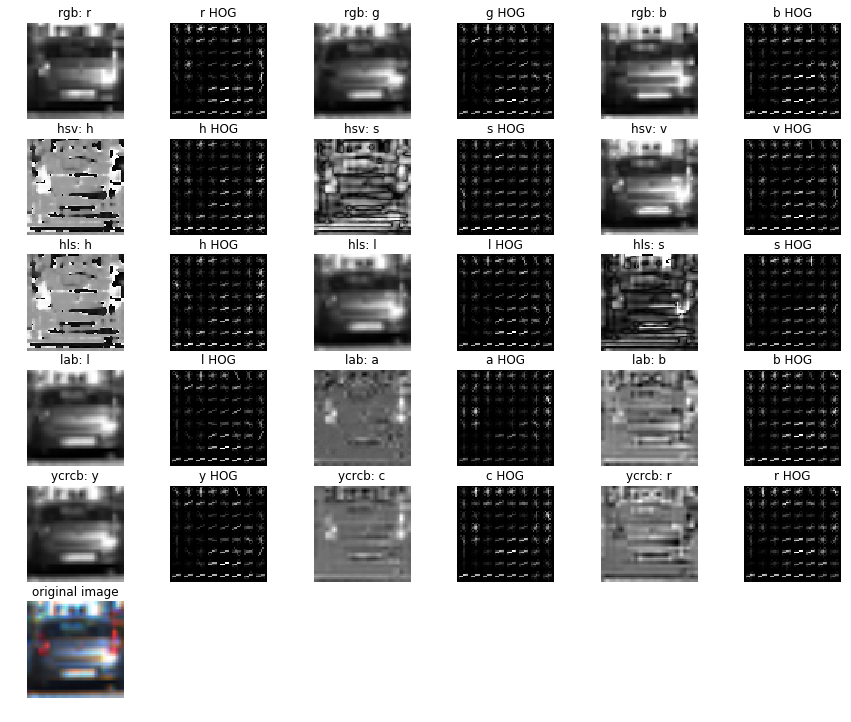

In [125]:
img = cv2.imread(files_vehicle[5])

color_spaces = ('rgb', 'hsv', 'hls', 'lab', 'ycrcb')
fig = plt.figure(figsize=(15,5))
subplot_i = 1

# Loop through all color spaces and display the same along with an image containing extracted features from hog.
# These features can be stacked together and be used to identify a vehicle.
for clrSpace in color_spaces:
    for channel in range(3):
        cvtImg = convertChannel(img, colorspace=clrSpace, useChannel=channel)
        plt.subplot(6,6,subplot_i)
        plt.imshow(cvtImg, cmap='gray')
        plt.subplots_adjust(top=2.00)
        plt.axis('off')
        plt.title('{}: {}'.format(clrSpace, clrSpace[channel]))
        subplot_i +=1
        feature, hog_img = get_hog_features(cvtImg, 9, 8, 2,vis=True)
        plt.subplot(6,6,subplot_i)
        plt.imshow(hog_img, cmap='gray')
        plt.subplots_adjust(top=2.00)
        plt.axis('off')
        plt.title('{} HOG'.format(clrSpace[channel]))
        subplot_i +=1

cvtImg = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.subplot(6,6,subplot_i)
plt.imshow(cvtImg)
plt.axis('off')
plt.title('original image')

plt.show()

## Sliding Window
### Reference - Udacity Self Driving Car Nanodegree - Lesson 20, section 30 & 32

In [36]:
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

## Visualizing Sliding Window
### Note - In the second image we use sliding window only in the ROI excluding the image portion that contains the sky.

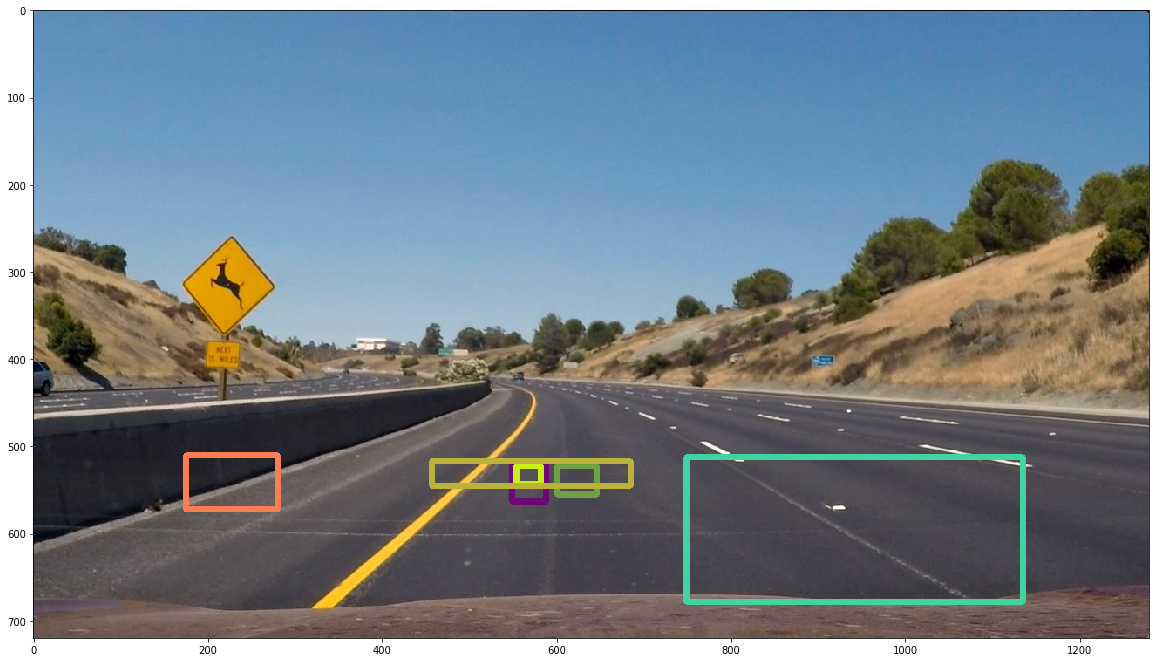

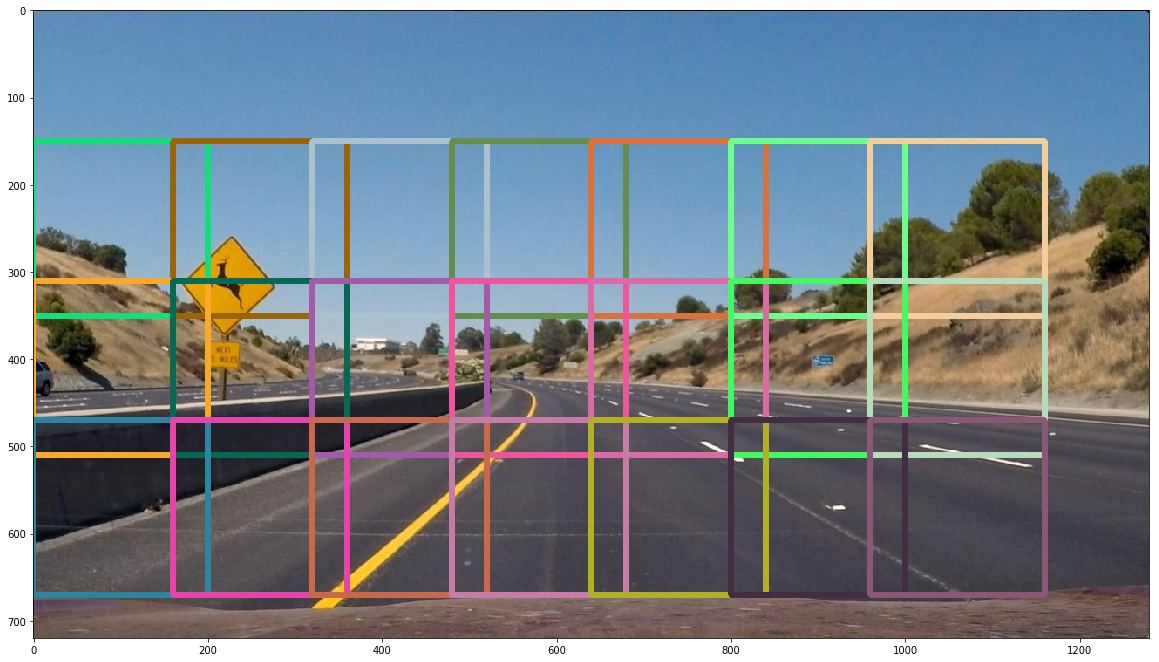

In [151]:
%matplotlib inline
image = mpimg.imread('test_images/test2.jpg')

'''
    The function that takes an image, a list of bounding boxes as input then draws boxes in that color on the output
'''

def draw_boxes(img, bboxes, color=(255, 0, 255), thick=6):
    # make a copy of the image
    draw_img = np.copy(img)
    # draw each bounding box on your image copy using cv2.rectangle()
    # Pick a random color for every box
    for b in bboxes:
        cv2.rectangle(draw_img, b[0],b[1], (np.random.randint(0, 255),np.random.randint(0, 255),np.random.randint(0, 255)), thick)
    # return the image copy with boxes drawn
    return draw_img # Change this line to return image copy with boxes
# Add bounding boxes in this format
bboxes = [((175, 572), (280, 510)), ((588, 563), (549, 518)), ((554, 543), (582, 522)), 
          ((601, 555), (646, 522)), ((457, 545), (685, 517)), ((749, 678), (1135, 512))]

'''
This function takes in the image and labels obtained using the scipy library and draws bounding boxes around them
'''
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    rects = []
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        rects.append(bbox)
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (255,0,0), 6)
    # Return the image and final rectangles
    return img, rects

result = draw_boxes(image, bboxes)

plt.figure(figsize=(20,20))
plt.imshow(result)
# Coordinates for the region of interest are defined using a range
w_list = slide_window(image, x_start_stop=[0, 1280], y_start_stop=[150, 720], xy_window=(200,200), xy_overlap=(0.2, 0.2))
result = draw_boxes(image, w_list)

plt.figure(figsize=(20,20))
plt.imshow(result)

In [153]:
'''
A similar function that resizes the image to 32x32, extracts the color channels and flattens them. 
Then, returns the the array where the channels are stacked.
'''
def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))
               

## Extract Features
### Reference - Udacity Self Driving Car Nanodegree - Lesson 20, section 29

In [130]:
# Define a function to return HOG features and visualization
#Reference https://medium.com/@jeremyeshannon
def extract_features(imgs, cspace='RGB', orient=9, pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Create an empy list of feature vectors
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion only if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        # Get the histogram of gradients by calling the above defined function.
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Add the new feature vector to the end of features list
        features.append(hog_features)
    # Return list of feature vectors
    return features
# Can be any color space but YUV works fine
colorspace = 'YUV'
orient = 11
pix_per_cell = 16
cell_per_block = 2
# Specify an individual channel(0, 1, 2) or use "ALL"
hog_channel = 'ALL' 
# We use to this to see how long it takes to extract the features from the dataset
t1 = time.time()

# Pass the file_vehicle list and extract the features for cars
vehicle_features = extract_features(files_vehicle, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
# Pass the file_notvehicle
notvehicle_features = extract_features(files_nonVehicle, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
t2 = time.time()
print(round(t2-t1, 2), 'Seconds to extract HOG features...')
# Create an array stack of feature vectors
X = np.vstack((vehicle_features, notvehicle_features)).astype(np.float64)  
# Define the labels vector
y = np.hstack((np.ones(len(vehicle_features)), np.zeros(len(notvehicle_features))))
# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=rand_state)

print(orient,'orientations')
print(pix_per_cell,'pixels per cell')
print(cell_per_block,'cells per block')
print('Feature vector size:', len(X_train[0]))



49.68 Seconds to extract HOG features...
11 orientations
16 pixels per cell
2 cells per block
Feature vector size: 1188


### Support Vecor Machines using Scikit-learn
### Reference - Udacity Self Driving Car Nanodegree - Lesson 18, section 11

In [131]:
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t1 = time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t1, 2), 'is the time in seconds to train')
# Check the score of the SVC
print('Test Accuracy of Support Vector Machines = ', round(svc.score(X_test, y_test), 4))

# Check the prediction time for a single sample
t1=time.time()
n_predict = 10
print('SVC prediction: ', svc.predict(X_test[0:n_predict]))
print('Correct Predictions for',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t1, 5), 'Time ins seconds to predict', n_predict,'labels')


1.61 is the time in seconds to train
Test Accuracy of Support Vector Machines =  0.9817
SVC prediction:  [ 1.  1.  0.  0.  1.  1.  1.  0.  1.  1.]
Correct Predictions for 10 labels:  [ 1.  1.  0.  0.  1.  1.  1.  0.  1.  1.]
0.00501 Time ins seconds to predict 10 labels


### Finding Cars
### Reference - Udacity Self Driving Car Nanodegree - Lesson 20, section 35

In [154]:
def find_cars(img, ystart, ystop, scale, cspace, hog_channel, svc, X_scaler, orient, 
              pix_per_cell, cell_per_block, spatial_size, hist_bins, show_all_rectangles=False):
    
    # declaring an empty array for the box coordinates
    rectangles = []
    img = img.astype(np.float32)/255
    img_tosearch = img[ystart:ystop,:,:]

    # apply color conversion if other than 'RGB'
    if cspace != 'RGB':
        if cspace == 'HSV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    else: ctrans_tosearch = np.copy(image)   
    
    # rescale image if other than 1.0 scale
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
    
    # select colorspace channel for HOG 
    if hog_channel == 'ALL':
        ch1 = ctrans_tosearch[:,:,0]
        ch2 = ctrans_tosearch[:,:,1]
        ch3 = ctrans_tosearch[:,:,2]
    else: 
        ch1 = ctrans_tosearch[:,:,hog_channel]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)+1  #-1
    nyblocks = (ch1.shape[0] // pix_per_cell)+1  #-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pixel per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)   
    if hog_channel == 'ALL':
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    # Computing HOG for patches by extracting the part of the hog already calculated for entire image.
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            if hog_channel == 'ALL':
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            else:
                hog_features = hog_feat1

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
           
            # Note- Not using color features but can be implemented if needed

            #print("hogggggg",hog_features)
            # Call the predict function
            # Note - The ,reshape(1,-1) is because we are passing only one sample. This can be removed if multiple samples
            # are to be annotated simultaneously.
            test_prediction = svc.predict(hog_features.reshape(1, -1))
            
            if test_prediction == 1 or show_all_rectangles:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                rectangles.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                
    return rectangles
  

In [139]:
test_img = mpimg.imread('./test_images/test1.jpg')

ystart = 400
ystop = 656
scale = 1.5
 # Only LUV and YCrCb give the aprrox. desired answer of 4 rectangles
colorspace = 'YCrCb'
orient = 11
pix_per_cell = 16
cell_per_block = 2
hog_channel = 'ALL'

rectangles = find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, orient, pix_per_cell, cell_per_block, None, None)
print('Number of boxes annotated - ',len(rectangles))

Number of boxes annotated -  4


## Viewing the prediction on a test image
- We call the function defined in the first section to draw boxes of random colors.

...


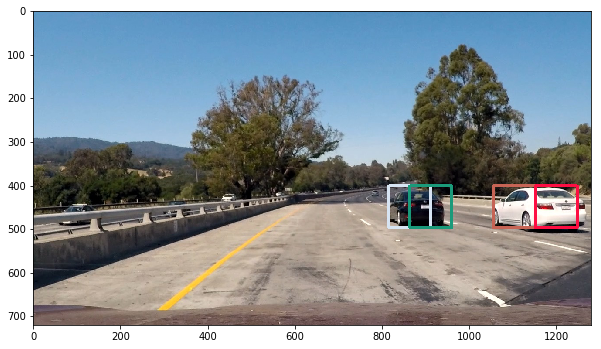

In [140]:
test_img_rects = draw_boxes(test_img, rectangles)
plt.figure(figsize=(10,10))
plt.imshow(test_img_rects)

## Trying out Various Configurations
- Changing the ROI
- Changing the Scaling
- Experimenting with YUV color space

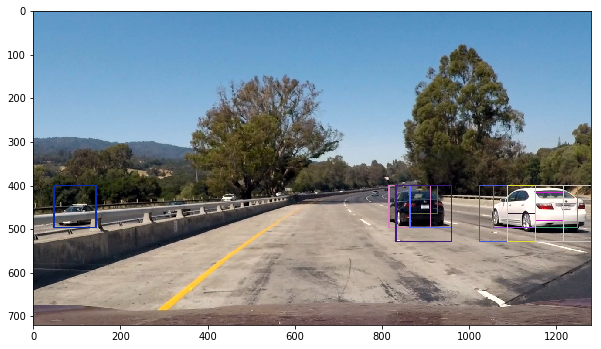

In [158]:
test_img = mpimg.imread('./test_images/test1.jpg')

def search_rect_with_different_configs(img):
    rectangles = []

    colorspace = 'YUV'
    orient = 11
    pix_per_cell = 16
    cell_per_block = 2
    hog_channel = 'ALL'

    ystart_stop=[(400,464),(416,480),(400,496),(432,528),(400,528),(432,560),(400,596),(464,660)]

    scale = 1.0
    rectangles.append(find_cars(test_img, ystart_stop[0][0], ystart_stop[0][1], scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))
    scale = 1.0
    rectangles.append(find_cars(test_img, ystart_stop[1][0], ystart_stop[1][1], scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))
    scale = 1.5
    rectangles.append(find_cars(test_img, ystart_stop[2][0], ystart_stop[2][1], scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))
    scale = 1.5
    rectangles.append(find_cars(test_img, ystart_stop[3][0], ystart_stop[3][1], scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))
    scale = 2.0
    rectangles.append(find_cars(test_img, ystart_stop[4][0], ystart_stop[4][1], scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))
    scale = 2.0
    rectangles.append(find_cars(test_img, ystart_stop[5][0], ystart_stop[5][1], scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))
    scale = 3.5
    rectangles.append(find_cars(test_img, ystart_stop[6][0], ystart_stop[6][1], scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))
    scale = 3.5
    rectangles.append(find_cars(test_img, ystart_stop[7][0], ystart_stop[7][1], scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))

    # Flattening list of lists
    rectangles = [item for sublist in rectangles for item in sublist] 
    return rectangles
rectangles=search_rect_with_different_configs(test_img)
test_img_rects = draw_boxes(test_img, rectangles, color='random', thick=2)
plt.figure(figsize=(10,10))
plt.imshow(test_img_rects)

## Heatmap Generation
### Reference - Udacity Self Driving Car Nanodegree - Lesson 20, section 37
- Heatmap are necessary tto find the overlapping regions
- Overlapping regions can be used to measure the confidence
- Confidence can be thresholded to remove false positives

2 cars found


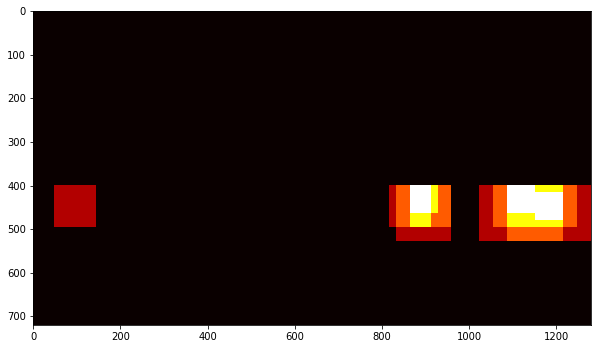

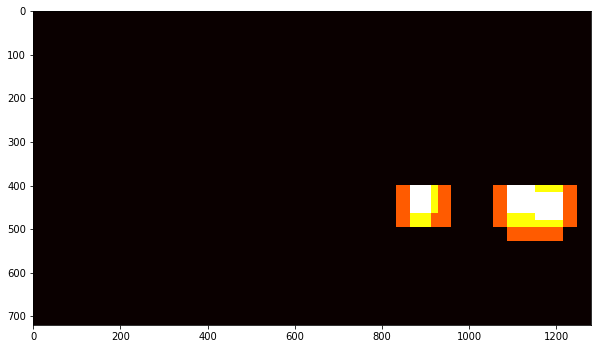

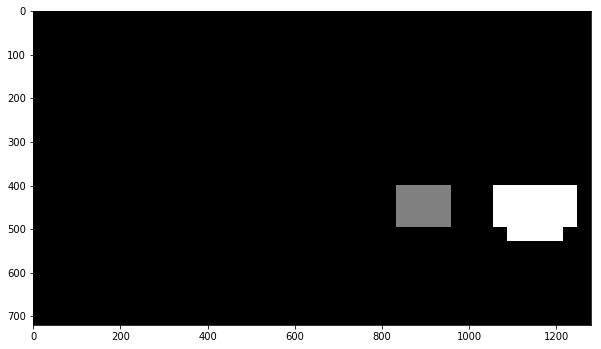

In [159]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

# Displaying the heatmap
heatmap_img = np.zeros_like(test_img[:,:,0])
heatmap_img = add_heat(heatmap_img, rectangles)
plt.figure(figsize=(10,10))
plt.imshow(heatmap_img, cmap='hot')

'''
Applying threshold to remove false positives.
'''
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

# Display the thresolded image in grayscale
heatmap_img = apply_threshold(heatmap_img, 1)
plt.figure(figsize=(10,10))
plt.imshow(heatmap_img, cmap='hot')

labels = label(heatmap_img)
plt.figure(figsize=(10,10))
plt.imshow(labels[0], cmap='gray')
print(labels[1], 'cars found')

## Drawing one box for a given heatmap concatenated area
### Reference - Udacity Self Driving Car Nanodegree - Lesson 20, section 37

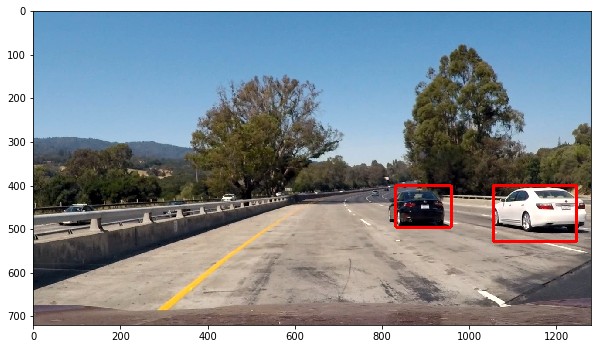

In [160]:
# Draw bounding boxes on a copy of the image
draw_img, rect = draw_labeled_bboxes(np.copy(test_img), labels)
# Display the image
plt.figure(figsize=(10,10))
plt.imshow(draw_img)


In [161]:
# Class to store data from video
class Vehicle_Detect():
    def __init__(self):
        # History of rectangles previous n frames
        self.prev_rects = [] 
        
    def add_rects(self, rects):
        self.prev_rects.append(rects)
        if len(self.prev_rects) > 15:
            # throw out oldest rectangle set(s)
            self.prev_rects = self.prev_rects[len(self.prev_rects)-15:]

def process_frame_for_video(img):

    rectangles=search_rect_with_different_configs(img)
    
    # add detections to the history
    if len(rectangles) > 0:
        det.add_rects(rectangles)
    
    heatmap_img = np.zeros_like(img[:,:,0])
    for rect_set in det.prev_rects:
        heatmap_img = add_heat(heatmap_img, rect_set)
    heatmap_img = apply_threshold(heatmap_img, 1 + len(det.prev_rects)//2)
     
    labels = label(heatmap_img)
    draw_img, rect = draw_labeled_bboxes(np.copy(img), labels)
    return draw_img

det = Vehicle_Detect()

test_out_file = 'output.mp4'
project_video = VideoFileClip('project_video.mp4')
test_output = project_video.fl_image(process_frame_for_video)
%time test_output.write_videofile(test_out_file, audio=False)

[MoviePy] >>>> Building video output.mp4
[MoviePy] Writing video output.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [05:31<00:00,  3.81it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output.mp4 

Wall time: 5min 32s


In [162]:
test_out_file = 'output_with_lane.mp4'
project_video = VideoFileClip('project_video_with_lane.mp4')
test_output = project_video.fl_image(process_frame_for_video)
%time test_output.write_videofile(test_out_file, audio=False)

[MoviePy] >>>> Building video output_with_lane.mp4
[MoviePy] Writing video output_with_lane.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [05:33<00:00,  3.77it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_with_lane.mp4 

Wall time: 5min 33s
